## ToDos:
1. Train-Test-Split
2. EDA
3. Impute missing values
4. BaseLine Model
5. Make Features and Target Stationary
6. Model 

In [114]:
# Import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
sns.set()

In [26]:
def plot_time_series(dataframe, min_date, max_date, size):
    if type(dataframe) == pd.Series:
        f, ax = plt.subplots(nrows=1, ncols=1, figsize=size)
        sns.lineplot(x=dataframe.index, y=dataframe)
        ax.set_xlim([datetime.strptime(min_date, "%Y-%m-%d"), datetime.strptime(max_date, "%Y-%m-%d")])

    else:
        f, ax = plt.subplots(nrows=len(dataframe.columns), ncols=1, figsize=size)
        for element in enumerate(dataframe.columns):
            sns.lineplot(x=dataframe.index, y=dataframe[element[1]], ax=ax[element[0]])
            ax[element[0]].set_xlim([datetime.strptime(min_date, "%Y-%m-%d"), datetime.strptime(max_date, "%Y-%m-%d")])

    plt.show()

In [195]:
df = pd.read_csv("./data/Aquifer_Petrignano.csv", index_col=0, parse_dates=True, dayfirst=True)

In [196]:
print(df.columns)
columns = ['Rf_BU', 'DtG_P24', 'DtG_P25', 'T_BU', 'T_Pe', 'V_Pe', 'H_FCP']
df.columns = columns

Index(['Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P24',
       'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra',
       'Temperature_Petrignano', 'Volume_C10_Petrignano',
       'Hydrometry_Fiume_Chiascio_Petrignano'],
      dtype='object')


In [197]:
df.head(1)

,Rf_BU,DtG_P24,DtG_P25,T_BU,T_Pe,V_Pe,H_FCP
Date,,,,,,,
2006-03-14,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN


In [198]:
df.count()

Rf_BU      4199
DtG_P24    5168
DtG_P25    5184
T_BU       4199
T_Pe       4199
V_Pe       5025
H_FCP      4199
dtype: int64

In [199]:
df.isna().sum()

Rf_BU      1024
DtG_P24      55
DtG_P25      39
T_BU       1024
T_Pe       1024
V_Pe        198
H_FCP      1024
dtype: int64

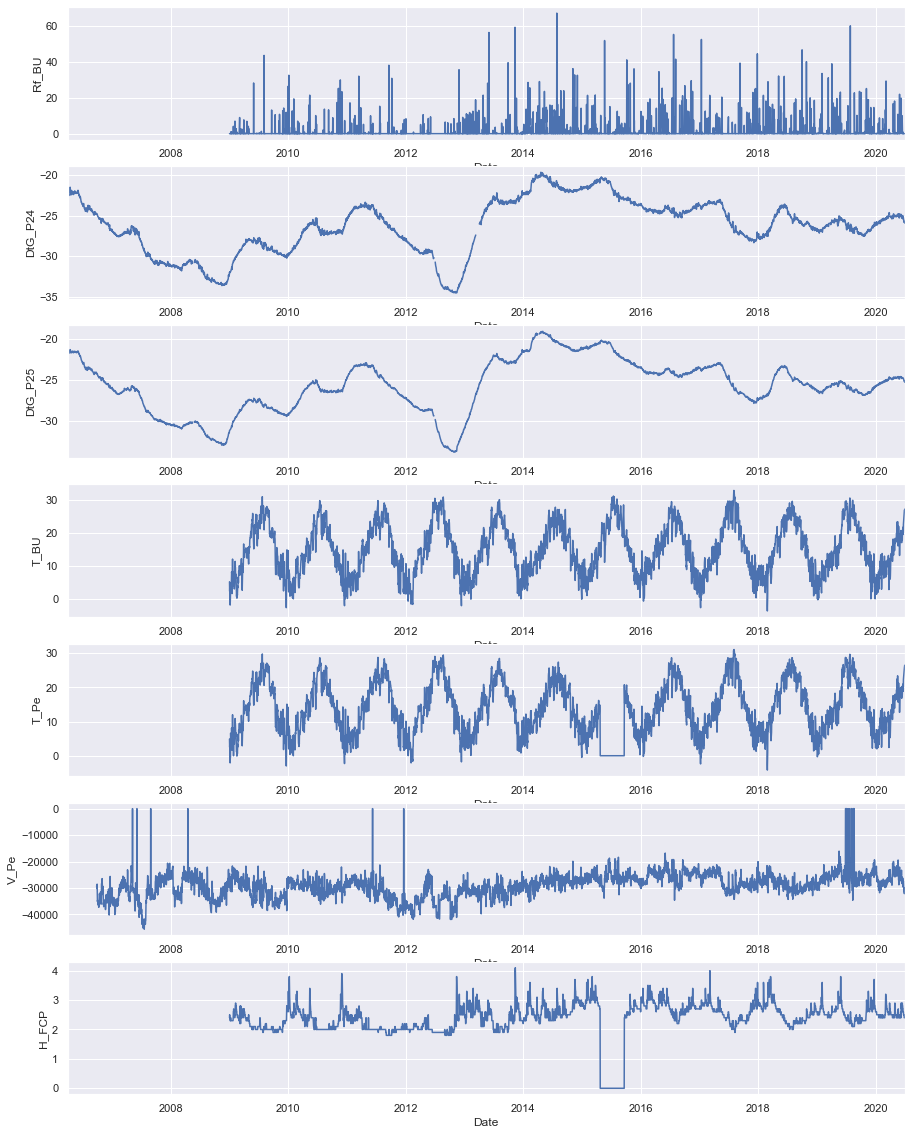

In [200]:
plot_time_series(df, '2006-04-01', '2020-06-30', (15, 20))

### Replace zero values of V_Pe, H_FCP, T_Pe with NaN

In [201]:
df_imputed = df.copy()

In [202]:
df_imputed['T_Pe'] = np.where(((df['T_Pe'] == 0) & (df['T_Pe'].shift(1) == 0)) | (df['T_Pe'].diff(-1) > 10) | ((df['T_Pe'] == 0) & (df['T_Pe'].shift(-1) == 0)), np.nan, df['T_Pe'])
df_imputed['V_Pe'] = np.where(df['V_Pe'] == 0, np.nan, df['V_Pe'])
df_imputed['H_FCP'] = np.where(df['H_FCP'] == 0, np.nan, df['H_FCP'])

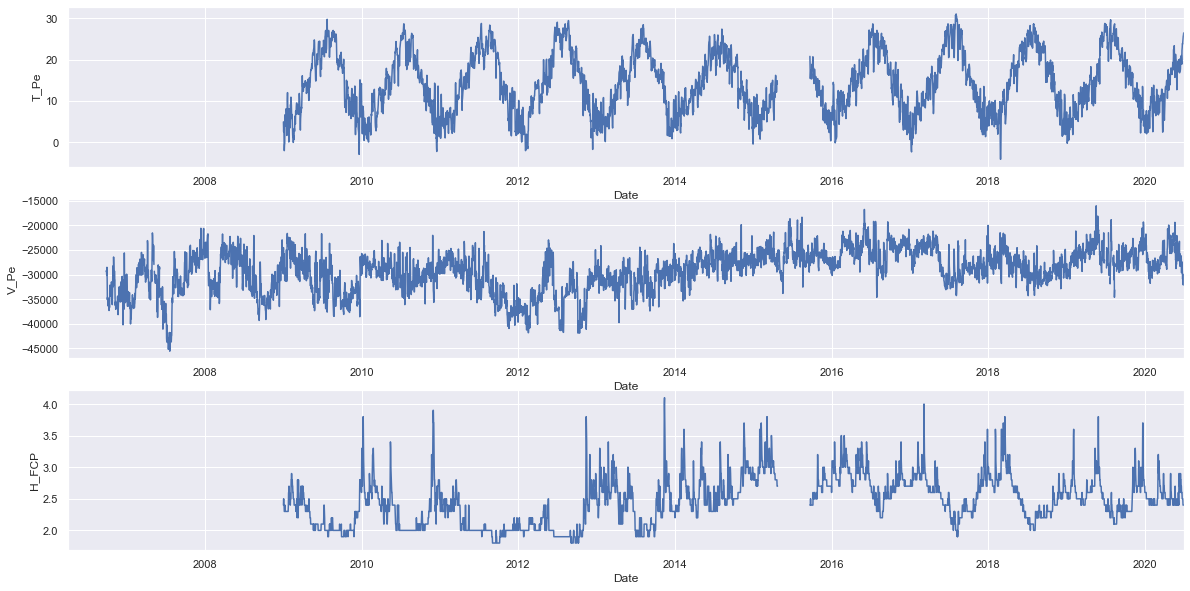

In [203]:
plot_time_series(df_imputed[['T_Pe', 'V_Pe', 'H_FCP']], '2006-04-01', '2020-06-30', (20,10))

### Replace NaN in dataset

#### T_Pe

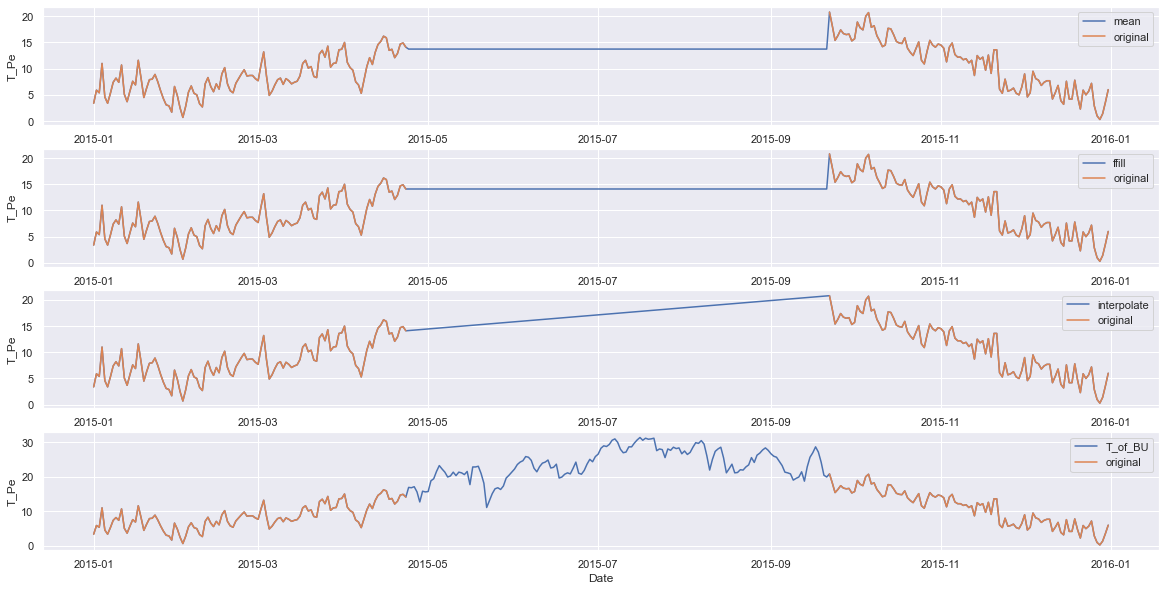

In [204]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2015']

sns.lineplot(x=subset.index, y=subset['T_Pe'].fillna(df['T_Pe'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['T_Pe'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['T_Pe'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[2])

sns.lineplot(x=subset.index, y=subset['T_Pe'].fillna(df['T_BU']), label='T_of_BU', ax=ax[3])
sns.lineplot(x=subset.index, y=subset['T_Pe'], label='original', ax=ax[3])

plt.legend()
plt.show()

#### V_Pe

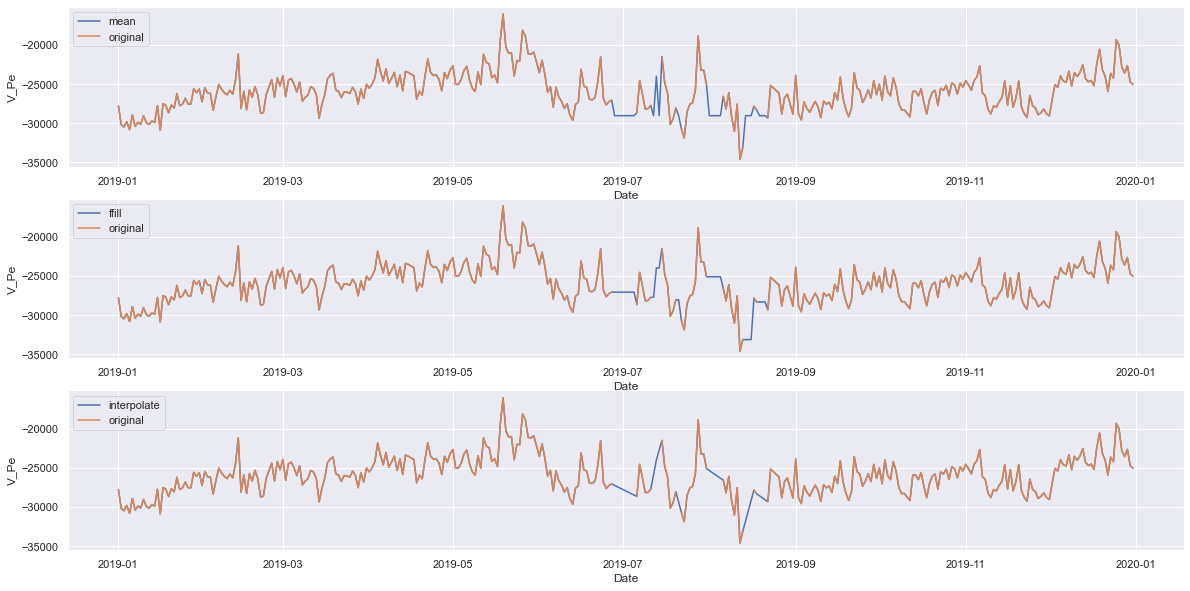

In [205]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2019']

sns.lineplot(x=subset.index, y=subset['V_Pe'].fillna(df['V_Pe'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['V_Pe'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['V_Pe'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['V_Pe'], label='original', ax=ax[2])

plt.legend()
plt.show()

#### H_FCP

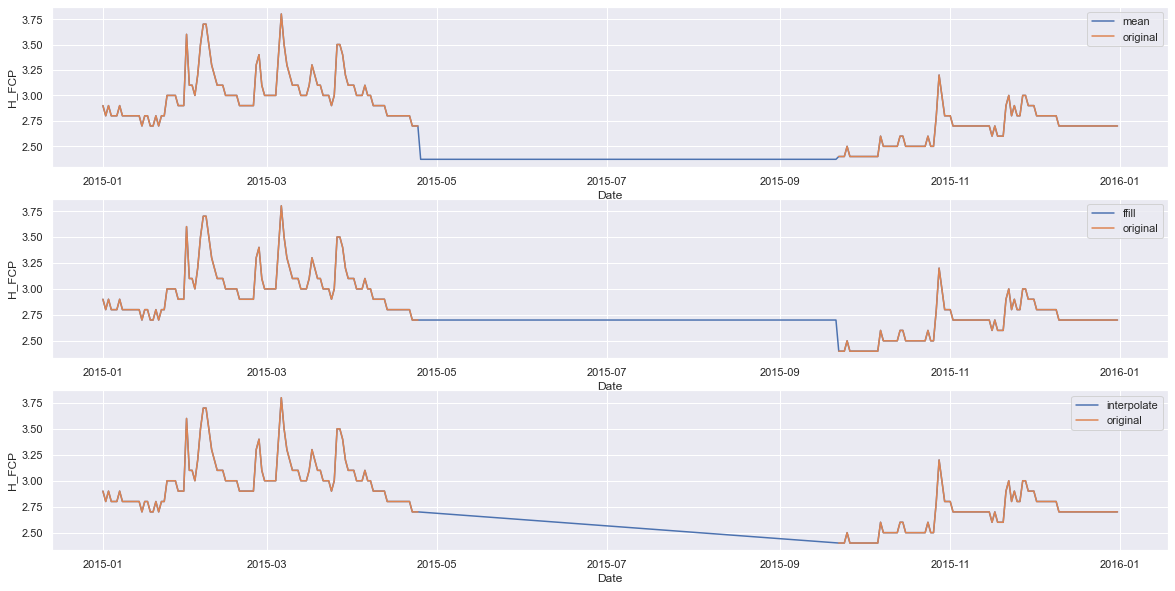

In [206]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2015']

sns.lineplot(x=subset.index, y=subset['H_FCP'].fillna(df['H_FCP'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['H_FCP'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['H_FCP'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['H_FCP'], label='original', ax=ax[2])

plt.legend()
plt.show()

#### DtG_P24

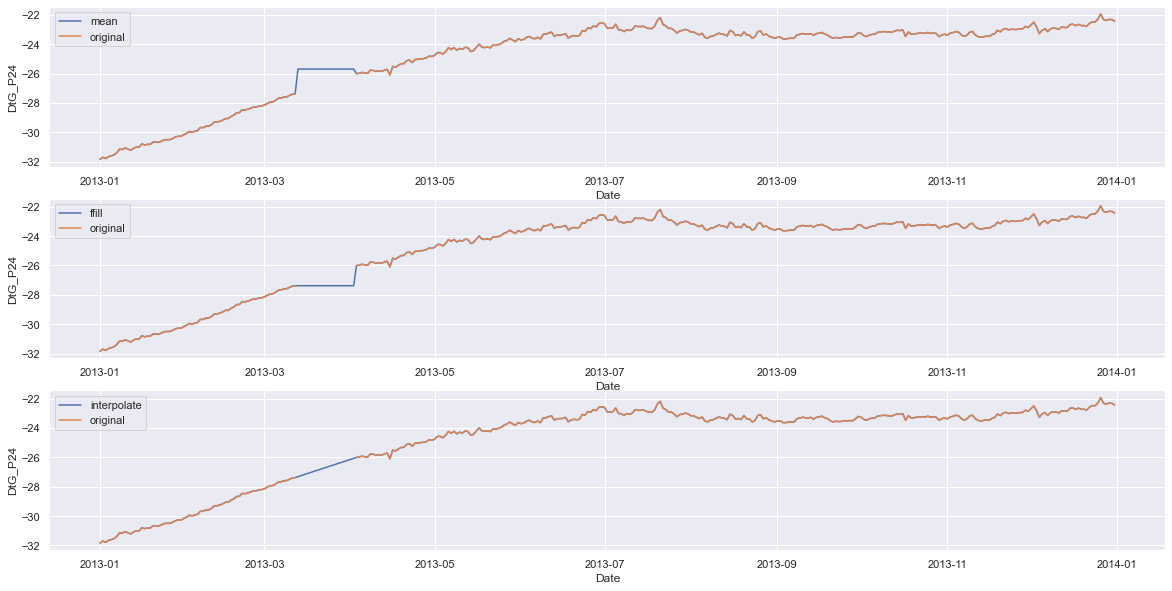

In [207]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
subset = df_imputed.loc['2013']

sns.lineplot(x=subset.index, y=subset['DtG_P24'].fillna(df['DtG_P25'].mean()), label='mean', ax=ax[0])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[0])

sns.lineplot(x=subset.index, y=subset['DtG_P24'].ffill(), label='ffill', ax=ax[1])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[1])

sns.lineplot(x=subset.index, y=subset['DtG_P24'].interpolate(), label='interpolate', ax=ax[2])
sns.lineplot(x=subset.index, y=subset['DtG_P24'], label='original', ax=ax[2])

plt.legend()
plt.show()

### Impute missing values

In [208]:
df_imputed['T_Pe'] = df['T_Pe'].fillna(df['T_BU'])
df_imputed['V_Pe'] = df_imputed['V_Pe'].interpolate()
df_imputed['H_FCP'] = df_imputed['H_FCP'].interpolate()
df_imputed['DtG_P25'] = df_imputed['DtG_P25'].interpolate()
df_imputed['DtG_P24'] = df_imputed['DtG_P24'].interpolate()

## Train-Test-Split

In [209]:
# Train-Test-Split

train = df_imputed[:-365]
y_train = train['DtG_P25']
test = df_imputed[-365:]
y_test = test['DtG_P25']

## Baseline Model

### Mean

In [210]:
def RSME(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_true, y_pred)).round(2)

In [211]:
y_train = train['DtG_P25']
y_pred_mean = pd.Series(y_train.mean(), index=test.index)

In [212]:
print(f'R2 score of mean prediction is: {round(r2_score(y_test, y_pred_mean),3)}')
print(f'RSME of mean prediction is: {RSME(y_test, y_pred_mean)}')

R2 score of mean prediction is: -0.0
RSME of mean prediction is: 0.74


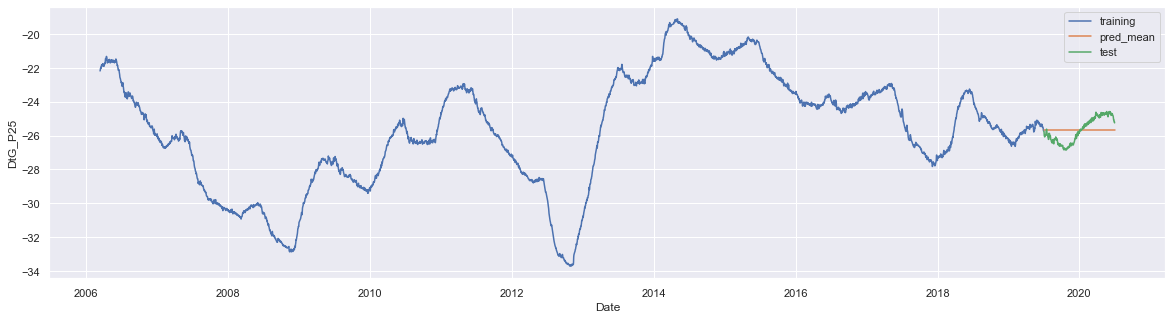

In [213]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = test.index, y=y_pred_mean, label='pred_mean')
sns.lineplot(x = test.index, y=y_test, label='test')

### General Trend

In [214]:
X_train_gen = pd.DataFrame(range(len(y_train)), index = y_train.index, columns= ['general_trend'])
X_test_gen = pd.DataFrame(range(len(y_test)), index = y_test.index, columns= ['general_trend'])
baseline_trend = LinearRegression()
baseline_trend.fit(X_train_gen, y_train)
y_pred_trend = baseline_trend.predict(X_test_gen)

In [215]:
print(f'R2 score of mean prediction is: {round(r2_score(y_test, y_pred_trend),3)}')
print(f'RSME of mean prediction is: {RSME(y_test, y_pred_trend)}')

R2 score of mean prediction is: -7.71
RSME of mean prediction is: 2.17


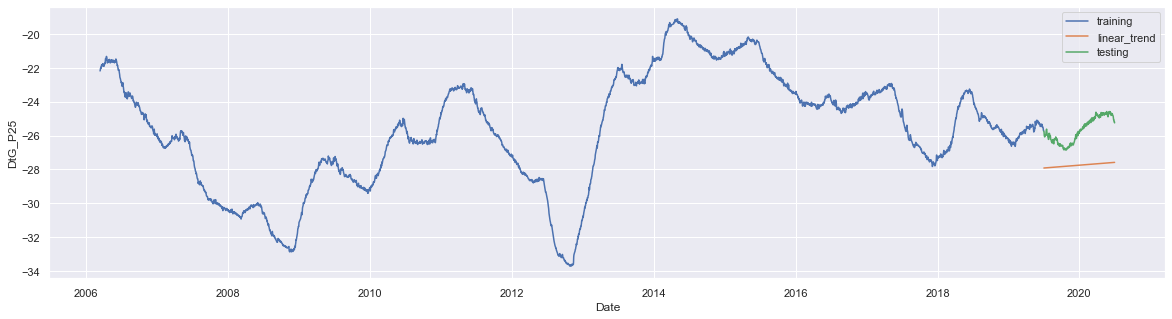

In [216]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = y_test.index, y=y_pred_trend, label='linear_trend')
sns.lineplot(x = y_test.index, y=y_test, label='testing')

### Seasonal

In [217]:
X_train_seas = pd.DataFrame(pd.get_dummies(y_train.index.month)).set_index(y_train.index)
X_test_seas = pd.DataFrame(pd.get_dummies(y_test.index.month)).set_index(y_test.index)
baseline_seas = LinearRegression()
baseline_seas.fit(X_train_seas, y_train)
y_pred_seas = baseline_seas.predict(X_test_seas)

In [218]:
print(f'R2 score of mean prediction is: {round(r2_score(y_test, y_pred_seas),3)}')
print(f'RSME of mean prediction is: {RSME(y_test, y_pred_seas)}')

R2 score of mean prediction is: 0.61
RSME of mean prediction is: 0.46


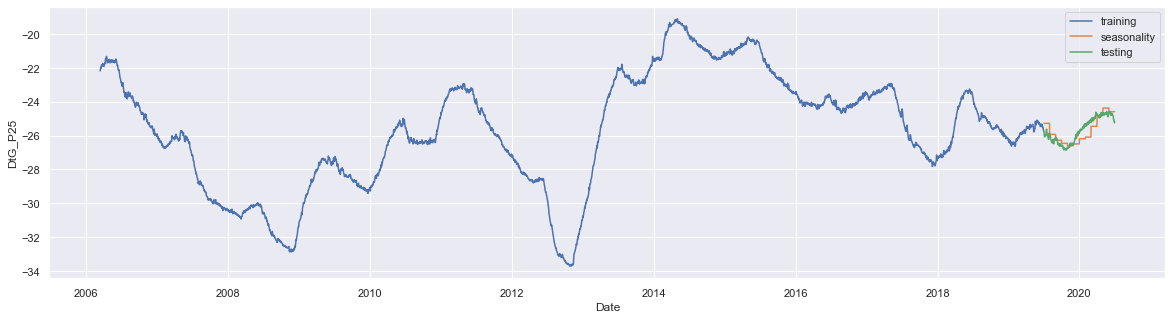

In [219]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
sns.lineplot(x = y_train.index, y=y_train, label='training')
sns.lineplot(x = y_test.index, y=y_pred_seas, label='seasonality')
sns.lineplot(x = y_test.index, y=y_test, label='testing')

### Decompose features

In [220]:
y_train_week = y_train.resample('7D').mean()

In [221]:
def decompose_features(series, per):
    results = seasonal_decompose(series, model='additive', period=per, extrapolate_trend='freq')
    f, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,10))
    sns.lineplot(x=series.index, y=results.observed, ax=ax[0])
    sns.lineplot(x=series.index, y=results.trend, ax=ax[1])
    sns.lineplot(x=series.index, y=results.seasonal, ax=ax[2])
    sns.lineplot(x=series.index, y=results.resid, ax=ax[3])
    plt.show()
    
    return results

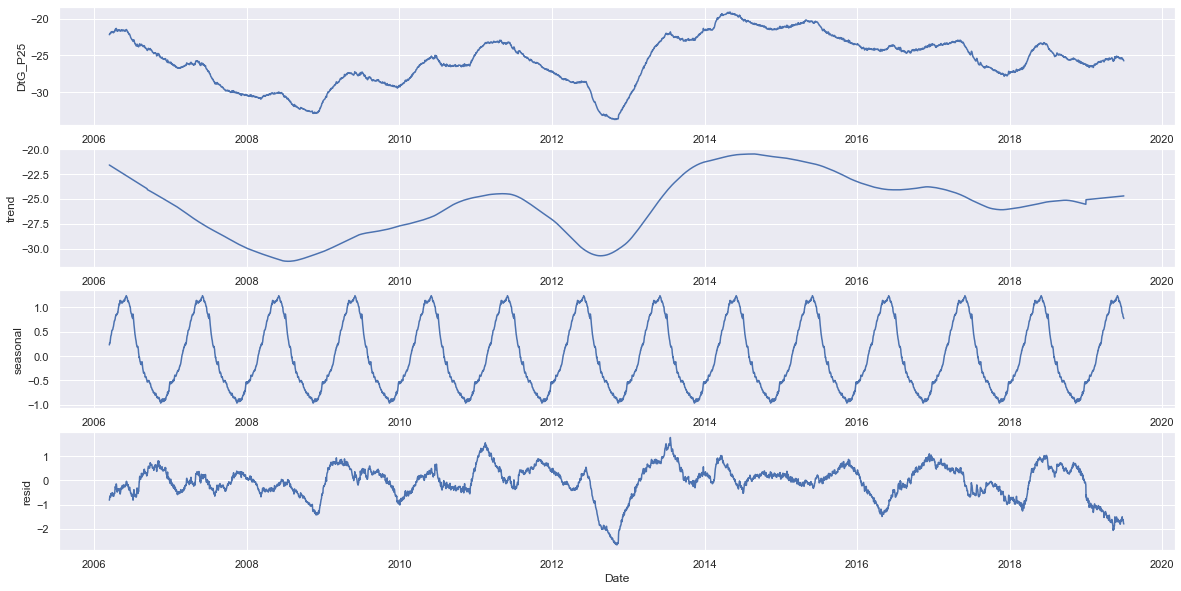

In [222]:
y_decompose = decompose_features(y_train, 365)

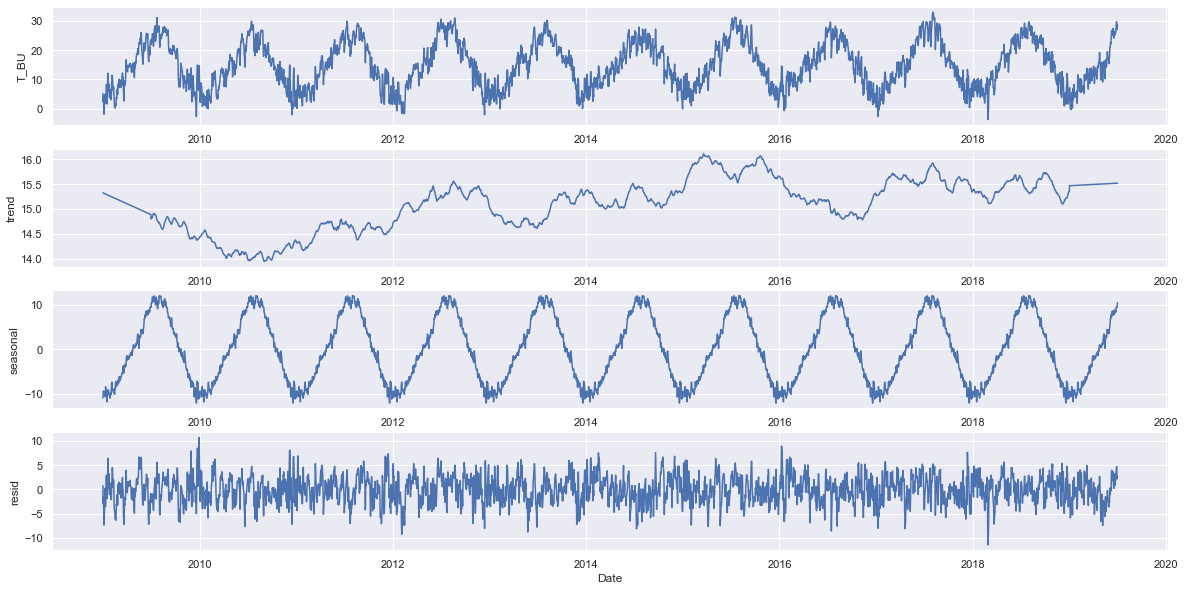

In [223]:
temp = train['T_BU'].dropna()
temp_decompose = decompose_features(temp, 365)

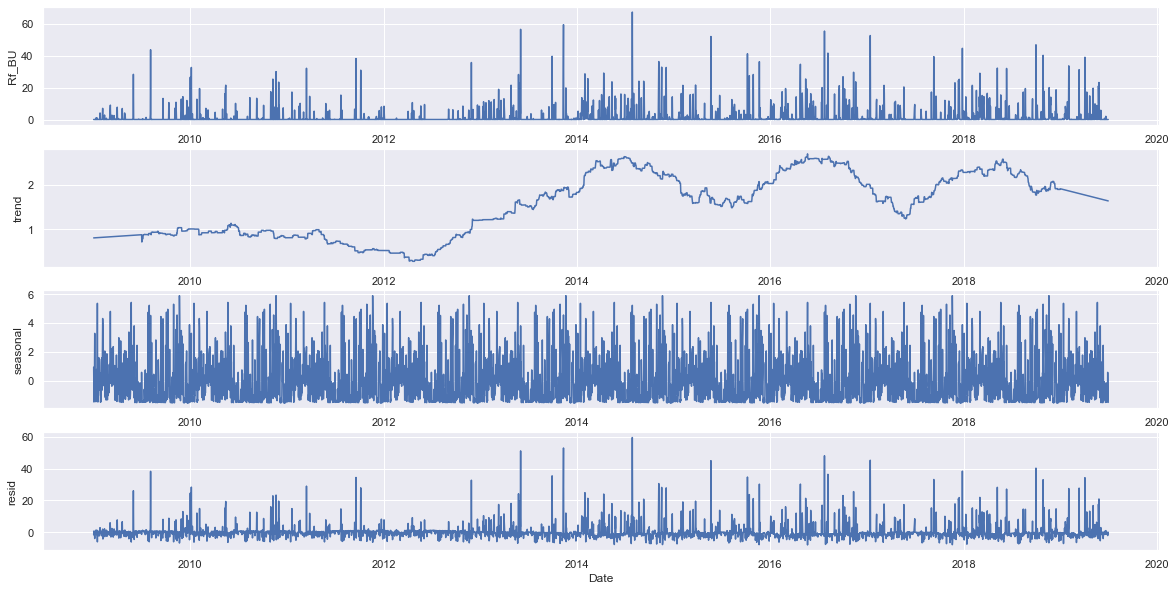

In [224]:
rainfall = train['Rf_BU'].dropna()
rainfall_decompose = decompose_features(rainfall, 365)

In [225]:
rainfall.head()

Date
2009-01-01    0.0
2009-01-02    0.0
2009-01-03    0.0
2009-01-04    0.0
2009-01-05    0.0
Name: Rf_BU, dtype: float64

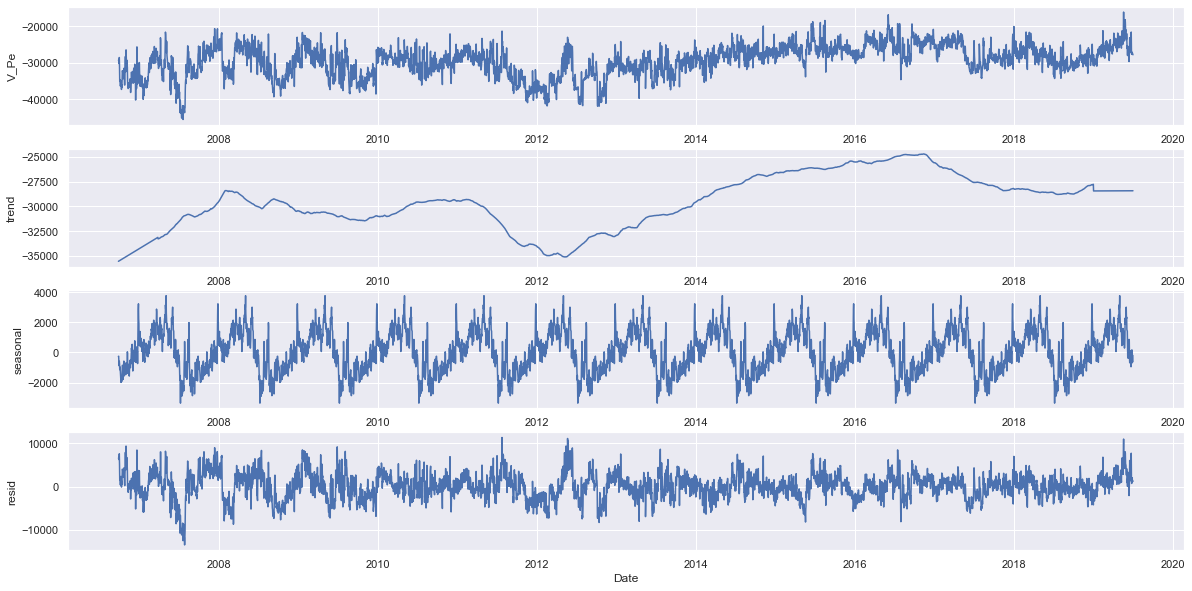

In [226]:
extraction = train['V_Pe'].dropna()
rainfall_decompose = decompose_features(extraction, 365)

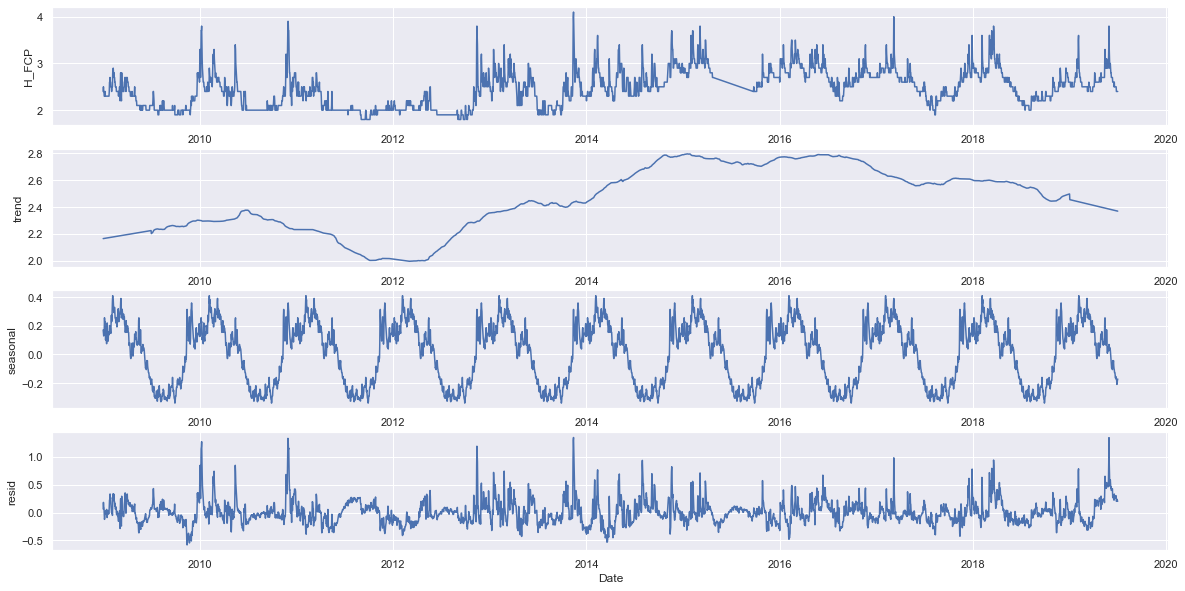

In [227]:
hydrometry = train['H_FCP'].dropna()
hydrometry_decompose = decompose_features(hydrometry, 365)

In [233]:
trend = train['T_BU'].dropna().rolling(365).mean()

In [281]:
seasonality = (train['T_BU'].dropna() - trend.dropna()).rolling(15).mean()

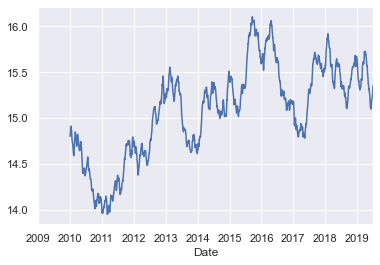

In [282]:
trend.plot()

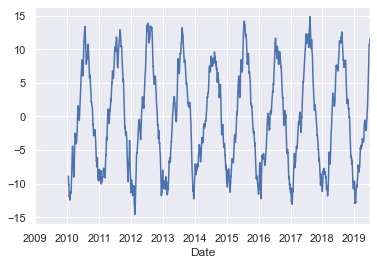

In [283]:
seasonality.plot()

In [284]:
residual = train['T_BU'].dropna() - trend - seasonality

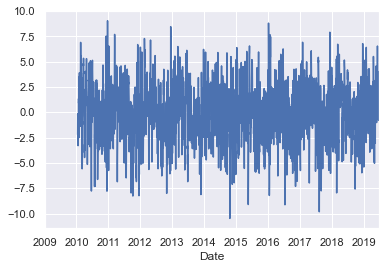

In [285]:
residual.plot()